In [3]:
try:
    from imutils import paths 
    import gdown

except:
    !pip install imutils 
    !pip install gdown 
    from imutils import paths 
    import gdown

! gdown https://drive.google.com/uc?id=1pGDcwitiFXy-CY9vO3wH3XprwjWgsQ8R

Downloading...
From (uriginal): https://drive.google.com/uc?id=1pGDcwitiFXy-CY9vO3wH3XprwjWgsQ8R
From (redirected): https://drive.google.com/uc?id=1pGDcwitiFXy-CY9vO3wH3XprwjWgsQ8R&confirm=t&uuid=1b72303e-5425-4d26-b05b-ae595abe266a
To: /kaggle/working/semi_super_augPipe.py
100%|██████████████████████████████████████| 12.2k/12.2k [00:00<00:00, 33.9MB/s]


In [1]:
from tensorflow import keras 
import tensorflow as tf 
from tensorflow.keras import models 
import os 
#from imutils import paths 
import matplotlib.pyplot as plt 
import numpy as np 

import shutil
import cv2
import random
from dataclasses import dataclass 
from tqdm import tqdm
import tempfile
from semi_super_augPipe import preprocess_image
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, GlobalMaxPooling2D, \
                                                GlobalAveragePooling2D, BatchNormalization, Flatten, ReLU

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
L2_PENALTY = 1.5*10e-6

In [25]:
class DataLoader: 
    """
        Class, will be useful for creating the BYOL dataset or dataset for the DownStream task 
            like classification or segmentation.
        Methods:
            __download_data(scope: private)
            __normalize(scope: private)
            __preprocess_img(scope: private)
             __get_valdata(scope: private)
            get_byol_dataset(scope: public)
            get_downstream_data(scope: public)
        
        Property:
            dname(dtype: str)        : dataset name(supports cifar10, cifar100).
            byol_augmentor(type      : ByolAugmentor): byol augmentor instance/object.
            nval(type: int)          : Number of validation data needed, this will be created by splitting the testing
                                       data.
            resize_shape(dtype: int) : Resize shape, bcoz pretrained models, might have a different required shape.
            normalize(dtype: bool)   : bool value, whether to normalize the data or not. 
    """
    
    def __init__(self, dname="cifar10", byol_augmentor=None, nval=5000,
                                             resize_shape=96, normalize=True, downstream_data=False): 
        assert (byol_augmentor != None or downstream_data), 'Need a BYOL Augment object'
        assert dname in ["cifar10", 'cifar100'], "dname should be either cifar10 or cifar100"
        assert nval <= 10_000, "ValueError: nval value should be <= 10_000"
        
        __train_data, __test_data = self.__download_data(dname)
        self.__train_X, self.__train_y = __train_data
        self.__train_X, self.__train_y = self.__train_X, self.__train_y
      #  self.__train_X, self.__train_y = self.__train_X[: 100], self.__train_y[: 100]
        self.__dtest_X, self.__dtest_y = __test_data 
        self.class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                                           'dog', 'frog', 'horse', 'sheep', 'truck']
        self.byol_augmentor = byol_augmentor
        self.__get_valdata(nval)
        self.resize_shape = resize_shape
        
        self.__normalize() if normalize else None
        self.min_obj_cov_value = 0.7
        self.color_jitter_value = 0.1
        
    def __len__(self): 
        return self.__train_X.shape[0] + self.__dtest_X.shape[0]
    
    def __repr__(self): 
        return f"Training Samples: {self.__train_X.shape[0]}, Testing Samples: {self.__dtest_X.shape[0]}"
    
    def __download_data(self, dname):
        """
            Downloads the data from the tensorflow website using the tensorflw.keras.load_data() method.
            Params:
                dname(type: Str): dataset name, it just supports two dataset cifar10 or cifar100
            Return(type(np.ndarray, np.ndarray))
                returns the training data and testing data
        """
        if dname == "cifar10": 
            train_data, test_data = tf.keras.datasets.cifar10.load_data()
        if dname == "cifar100": 
            train_data, test_data = tf.keras.datasets.cifar100.load_data()
            
        return train_data, test_data
    
    def __normalize(self): 
        """
            this method, will used to normalize the inputs.
        """
        self.__train_X = self.__train_X / 255.0
        self.__dtest_X = self.__dtest_X / 255.0
    
    def __preprocess_img(self, image): 
        """
            this method, will be used by the get_byol_dataset methos, which does a convertion of 
            numpy data to tensorflow data.
            Params:
                image(type: np.ndarray): image data.
            Returns(type; (np.ndarray, np.ndarray))
                returns the two different augmented views of same image.
        """
        try: 
            image = tf.image.convert_image_dtype(image, tf.float32)
            image = tf.image.resize(image, (self.resize_shape, self.resize_shape))
         #   view1 = self.byol_augmentor.augment(image, self.resize_shape)
          #  view2 = self.byol_augmentor.augment(image, self.resize_shape)
            
            view1 = preprocess_image(image = image, 
                                   height = 96, 
                                   width  = 96, 
                                   cjs = self.color_jitter_value,
                                   m_obj_cov = self.min_obj_cov_value,
                                   a_range = (self.min_obj_cov_value, 1.0))
            
            view2 = preprocess_image(image = image, 
                                   height = 96, 
                                   width  = 96, 
                                   cjs = self.color_jitter_value,
                                   m_obj_cov = self.min_obj_cov_value,
                                   a_range = (self.min_obj_cov_value, 1.0))
            
            return (view1, view2)
        
        except Exception as err:
            return err
    
    def get_byol_dataset(self, batch_size, dataset_type="train"):
        """
            this method, will gives the byol dataset, which is nothing but a tf.data.Dataset object.
            Params:
                batch_size(dtype: int)    : Batch Size.
                dataset_type(dtype: str)  : which type of dataset needed, (train, test or val)
                
            return(type: tf.data.Dataset)
                returns the tf.data.Dataset for intended dataset_type, by preprocessing and converting 
                the np data.
        """
        try:
            if dataset_type == "train":
                tensorflow_data = tf.data.Dataset.from_tensor_slices((self.__train_X))
                tensorflow_data = (
                tensorflow_data
                    .map(self.__preprocess_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                    .shuffle(1024)
                    .batch(batch_size, drop_remainder=True)
                    .prefetch(tf.data.experimental.AUTOTUNE)
                )
                return tensorflow_data  
            
            if dataset_type == "test":
                tensorflow_data = tf.data.Dataset.from_tensor_slices((self.__test_X))
                tensorflow_data = (
                tensorflow_data
                    .map(self.__preprocess_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                    .shuffle(1024)
                    .batch(batch_size, drop_remainder=True)
                    .prefetch(tf.data.experimental.AUTOTUNE)
                )
                return tensorflow_data  
            
            if dataset_type == "val":
                tensorflow_data = tf.data.Dataset.from_tensor_slices((self.__val_X))
                tensorflow_data = (
                tensorflow_data
                    .map(self.__preprocess_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                    .shuffle(1024)
                    .batch(batch_size, drop_remainder=True)
                    .prefetch(tf.data.experimental.AUTOTUNE)
                )
                return tensorflow_data  
        
        except Exception as err:
            return err
    
    def get_downstream_data(self): 
        """
            this method returns the dataset for the downstream task.
        """
        return (self.__train_X, self.__train_y)#, (self.__val_X, self.__val_y), (self.__test_X, self.__test_y)
    
    def __get_valdata(self, nval):
        """
            this method is used to create a validation data by randomly sampling from the testing data.
            Params:
                nval(dtype: Int); Number of validation data needed, rest of test_X.shape[0] - nval, will be 
                                  testing data size.
            returns(type; np.ndarray, np.ndarray):
                returns the testing and validation dataset.
        """
        try: 
            ind_arr = np.arange(10_000)
            val_inds = np.random.choice(ind_arr, nval)
            test_inds = [i for i in ind_arr if not i in val_inds]

            self.__test_X, self.__test_y = self.__dtest_X[test_inds], self.__dtest_y[test_inds]
            self.__val_X, self.__val_y = self.__dtest_X[val_inds], self.__dtest_y[val_inds]
            
        except Exception as err:
            raise err    
            
    def __reshape_downstream_img(self, img, y):
        img = tf.image.resize(img, (96, 96))
        return img, y
        
    def get_downstream_tf_dataset(self, batch_size, dataset_type="train"): 
        """
             this method, will gives the downstream dataset, which is of type tf.data.Dataset object.
            Params:
                batch_size(dtype: int)    : Batch Size.
                dataset_type(dtype: str)  : which type of dataset needed, (train, test or val)
                
            return(type: tf.data.Dataset)
                returns the tf.data.Dataset for intended dataset_type, by preprocessing and converting 
                the np data.
        """
        assert dataset_type in ["train", "test", "val"], "Given dataset type is not valid"
        try:
            if dataset_type == "train":
                tensorflow_data = tf.data.Dataset.from_tensor_slices((self.__train_X, self.__train_y))
                tensorflow_data = (
                tensorflow_data
                    .map(self.__reshape_downstream_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                    .shuffle(1024)
                    .batch(batch_size, drop_remainder=True)
                    .prefetch(tf.data.experimental.AUTOTUNE)
                )
                return tensorflow_data  
            
            if dataset_type == "test":
                tensorflow_data = tf.data.Dataset.from_tensor_slices((self.__test_X, self.__test_X))
                tensorflow_data = (
                tensorflow_data
                    .map(self.__reshape_downstream_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                    .shuffle(1024)
                    .batch(batch_size, drop_remainder=True)
                    .prefetch(tf.data.experimental.AUTOTUNE)
                )
                return tensorflow_data  
            
            if dataset_type == "val":
                tensorflow_data = tf.data.Dataset.from_tensor_slices((self.__val_X, self.__val_y))
                tensorflow_data = (
                tensorflow_data
                    .map(self.__reshape_downstream_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                    .shuffle(1024)
                    .batch(batch_size, drop_remainder=True)
                    .prefetch(tf.data.experimental.AUTOTUNE)
                )
                return tensorflow_data  
        
        except Exception as err:
            return err

In [8]:
class ByolAugmentor: 
    """
        This class is used for the data augmentation for the byol model.
        Methods: 
            __random_crop_flip_resize(scope: private)
            __random_color_distortion(scope: private)
            augment(scope: public)
    """
    def __init__(self): 
        pass 
    
    @tf.function
    def __random_crop_flip_resize(self, image, resize_shape):
        """
            this method does a random crop with height and width of the crop are sampled randomly. it does the 
            crop with the height and width, then it does a resizing again to the original shape. And also it does
            a flip of the image
            Params:
                image(type: tf.Tensor)   : image data of type tensor.
                resize_shape(type: int)  : Size of the image.
            Return(type: tf.Tensor)
                returns the crop and resized image.
        """
        try: 
            h_crop = tf.cast(tf.random.uniform(shape=[], minval=13, maxval=33, dtype=tf.int32), tf.float32)
            w_crop = h_crop * tf.random.uniform(shape=[], minval=0.67, maxval=1.0)
            h_crop, w_crop = tf.cast(h_crop, tf.int32), tf.cast(w_crop, tf.int32)
            opposite_aspectratio = tf.random.uniform(shape=[])
            if opposite_aspectratio < 0.5:
                h_crop, w_crop = w_crop, h_crop
            image = tf.image.random_crop(image, size=[h_crop, w_crop, 3])

            horizontal_flip = tf.random.uniform(shape=[])
            if horizontal_flip < 0.5:
                image = tf.image.random_flip_left_right(image)

            image = tf.image.resize(image, size=[resize_shape, resize_shape])
            return image
        
        except Exception as err:
            return err
    
    @tf.function
    def __random_color_distortion(self, image):
        """
            this method, will do the color disortion augmentation for the given image.
            Params:
                image(type: tf.Tensor)   : image data of type tensor.
            Return(type: tf.Tensor)
                returns the crop and resized image.
        """
        try: 
            color_jitter = tf.random.uniform(shape=[])
            if color_jitter < 0.8:
                image = tf.image.random_brightness(image, max_delta=0.4)
                image = tf.image.random_contrast(image, lower=0.6, upper=1.4)
                image = tf.image.random_saturation(image, lower=0.6, upper=1.4)
                image = tf.image.random_hue(image, max_delta=0.1)
                image = tf.clip_by_value(image, 0, 1)

            color_drop = tf.random.uniform(shape=[])
            if color_drop < 0.2:
                image = tf.image.rgb_to_grayscale(image)
                image = tf.tile(image, [1, 1, 3])

            return image
        
        except Exception as error:
            return error
    
    @tf.function
    def augment(self, image, resize_shape): 
        """
            this method will include all the augmentation as a pipeline(random crop, random flip, resize, and 
            color disortion), this augment method will be used by DataLoader class.
            Params:
                image(type: tf.Tensor)   : image data of type tensor.
                resize_shape(type: int)  : Size of the image.
            Return(type: tf.Tensor)
                returns the crop and resized image.
                
        """
        try: 
            image = self.__random_crop_flip_resize(image, resize_shape)
            image = self.__random_color_distortion(image)

            return image
        
        except Exception as error:
            print(error, error)
            return error

In [8]:
byol_augmentor = ByolAugmentor()

In [9]:
byol_dataloader = DataLoader("cifar10", byol_augmentor)
byol_dataloader

Training Samples: 50000, Testing Samples: 10000

In [10]:
train_ds = byol_dataloader.get_byol_dataset(32, "train")

In [11]:
def visualize(train_ds):
    for batch in train_ds.take(1):
        pass

    plt.figure(figsize=(7, 7))

    ax1 = plt.subplot(2, 2, 1)
    ax1.grid(False)
    plt.imshow(batch[0][0].numpy().astype('float32'), interpolation = 'none', vmin = 0, vmax = 1)
    ax2 = plt.subplot(2, 2, 2)
    ax2.grid(False)
    plt.imshow(batch[1][0].numpy().astype('float32'), interpolation = 'none', vmin = 0, vmax = 1)

    ax3 = plt.subplot(2, 2, 3)
    plt.hist(batch[0][0].numpy().ravel())
    ax4 = plt.subplot(2, 2, 4, sharey = ax3, sharex=ax3)
    plt.hist(batch[1][0].numpy().ravel())
    plt.show()
    

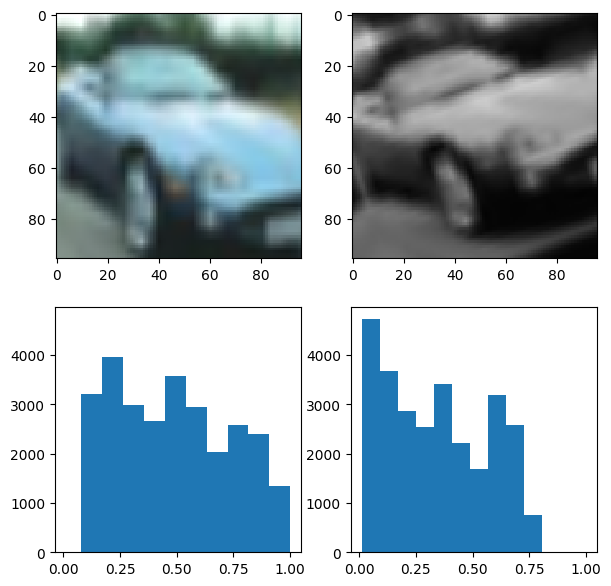

In [12]:
visualize(train_ds)

In [13]:
# References:
# https://sthalles.github.io/keras-regularizer/ 
# https://stackoverflow.com/questions/48330137/adding-regularizer-to-an-existing-layer-of-a-trained-model-without-resetting-wei
def add_regularization(model, regularizer = tf.keras.regularizers.l2(0.0001)):
    """
        Function to add l2 regularisation penalty to each layer of a built in keras model.
        Args:
            model (tf.keras.models) : Input model whose layer's you want to regularize
            regularizer ( tf.keras.regularizers.l2) : object indicating l2 penalty to be applied.

        Returns:
            l2 regularised keras model
    """
    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
        print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
        return model
    
    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
                setattr(layer, attr, regularizer)

    model_json = model.to_json()
    
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    model = tf.keras.models.model_from_json(model_json)
    
    model.load_weights(tmp_weights_path, by_name=True)
    return model

In [14]:
def get_predictor(input_dim, hidden_dims1, 
                        hidden_dims2, l2_reg_penalty):
    """
        Function to build the predictor newtork(q), for one view of the network
        Params:
            input_dim (dtye; int)          : Input vector dimensionality
            l2_reg_penalty (dtype; float)  : L2 penalty value.
            hidden_dims1(dtype: Int)       : Hidden layer1 neuron
            hidden_dims2 (dtype: int)      : Hidden layer2 neuron

        Return(type; keras.models.Model):
            The keras model of the predictor network(q)
    """
  
    regularizer = tf.keras.regularizers.l2(l2_reg_penalty)
    
    _input = Input(input_dim, name='Predictor input1')
  
    x = Dense(hidden_dims1, kernel_regularizer = regularizer, name="dense1")(_input)
    x = BatchNormalization(name='bn1')(x)
    x = ReLU(name='relu1')(x)
    _output = Dense(hidden_dims2, kernel_regularizer = regularizer, name='dense2')(x)

    return keras.models.Model(_input, _output, name='Predictor')


In [15]:
predictor = get_predictor(512, 512, 128, L2_PENALTY)
predictor.summary()

Model: "Predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Predictor input1 (InputLaye  [(None, 512)]            0         
 r)                                                              
                                                                 
 dense1 (Dense)              (None, 512)               262656    
                                                                 
 bn1 (BatchNormalization)    (None, 512)               2048      
                                                                 
 relu1 (ReLU)                (None, 512)               0         
                                                                 
 dense2 (Dense)              (None, 128)               65664     
                                                                 
Total params: 330,368
Trainable params: 329,344
Non-trainable params: 1,024
_______________________________________________

In [16]:
def get_projector(input_dim, hidden_dims1, 
                        hidden_dims2, l2_reg_penalty):
    """
        this function, build the Projection newtork(g), for one view of the network
        Params:
            input_dim (dtye; int)          : Input vector dimensionality
            l2_reg_penalty (dtype; float)  : L2 penalty value.
            hidden_dims1(dtype: Int)       : Hidden layer1 neuron
            hidden_dims2 (dtype: int)      : Hidden layer2 neuron

        Return(type; keras.models.Model):
            The keras model of the Projection network(g)
    """
  
    regularizer = tf.keras.regularizers.l2(l2_reg_penalty)
    
    _input = Input(input_dim, name='Projection input1')
  
    x = Dense(hidden_dims1, kernel_regularizer = regularizer, name="dense1")(_input)
    x = BatchNormalization(name='bn1')(x)
    x = ReLU(name='relu1')(x)
    _output = Dense(hidden_dims2, kernel_regularizer = regularizer, name='dense2')(x)

    return keras.models.Model(_input, _output, name='Projection')


In [17]:
projection = get_projector(128, 256, 128, L2_PENALTY)
projection.summary()

Model: "Projection"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Projection input1 (InputLay  [(None, 128)]            0         
 er)                                                             
                                                                 
 dense1 (Dense)              (None, 256)               33024     
                                                                 
 bn1 (BatchNormalization)    (None, 256)               1024      
                                                                 
 relu1 (ReLU)                (None, 256)               0         
                                                                 
 dense2 (Dense)              (None, 128)               32896     
                                                                 
Total params: 66,944
Trainable params: 66,432
Non-trainable params: 512
__________________________________________________

In [18]:
def get_encoder_projector(input_shape, hidden_dims1, 
                                hidden_dims2, l2_reg_penalty):
    """
        this function, will build a encoder(f) with the projection(g)
        Params:
            input_shape (dtye; tuple)      : Input image dimension
            l2_reg_penalty (dtype; float)  : L2 penalty value.
            hidden_dims1(dtype: Int)       : Hidden layer1 neurons, for the projection(q) model.
            hidden_dims2 (dtype: int)      : Hidden layer2 neurons, for the projection(q) model.

        Return(type; keras.models.Model):
            The keras model of the Projection network(g)
    """
    # f -> Base encoder, g -> projector, q -> predictor
    f = tf.keras.applications.MobileNet(include_top=False, 
                                           weights=None, input_shape=input_shape)
  
    regularizer = tf.keras.regularizers.l2(l2_reg_penalty)

   # reg_f = add_regularization(f, regularizer)
   # reg_f.trainable = True
    f.trainable = True
    _input = Input(input_shape, name="Encoder Input")
    y = f(_input, training=True)
    flatten = GlobalMaxPooling2D(name="gmp1")(y)
    
    g_input_dims = flatten.shape[-1]
    g = get_projector(g_input_dims, hidden_dims1, hidden_dims2, l2_reg_penalty)
    _output = g(flatten)
    
    return keras.models.Model(_input, _output, name="Encoder with Projection")

In [19]:
m = get_encoder_projector((32, 32, 3), 128, 128, L2_PENALTY)
m.summary()

Model: "Encoder with Projection"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder Input (InputLayer)  [(None, 32, 32, 3)]       0         
                                                                 
 mobilenet_1.00_32 (Function  (None, 1, 1, 1024)       3228864   
 al)                                                             
                                                                 
 gmp1 (GlobalMaxPooling2D)   (None, 1024)              0         
                                                                 
 Projection (Functional)     (None, 128)               148224    
                                                                 
Total params: 3,377,088
Trainable params: 3,354,944
Non-trainable params: 22,144
_________________________________________________________________


In [ ]:
class ByolModel(keras.models.Model): 
    def __init__(self, online_encoder_proj, 
                     target_encoder_proj, online_predictor): 
        super(ByolModel, self).__init__()
        self.f_g_online = online_encoder_proj
        self.q_online = online_predictor
        self.f_g_target = target_encoder_proj
        self.loss_tracker = keras.metrics.Mean()
        
    def call(self, inputs): 
        out = self.f(inputs)
        return out 
    
    def train_step(self, inputs, optimizer):
        # v1, v2 -> view1, view2
        v1, v2 = inputs
        z_target_1 = self.f_g_target(v1, training=True)
        z_target_2 = self.f_g_target(v2, training=True)
        
        with tf.GradientTape(persistent=True) as tape:
            z_online_1 = self.f_g_online(v1, training=True)
            p_online_1 = self.q_online(z_online_1, training = True)

            z_online_2 = self.f_g_online(v2, training=True)
            p_online_2 = self.q_online(z_online_2, training = True)

            p_online = tf.concat([p_online_1, p_online_2], axis=0)
            z_target = tf.concat([z_target_2, z_target_1], axis=0)
            loss = self.compute_loss(p_online, z_target)

        # online encoder prohection update
        params = self.f_g_online.trainable_weights
        grads = tape.gradient(loss, params)
        optimizer.apply_gradients(zip(grads, params))

        # predictor update
        params = self.q_online.trainable_weights
        grads = tape.gradient(loss, params)
        optimizer.apply_gradients(zip(grads, params))
        
        self.loss_tracker.update_state(loss)
        del tape
        return {"loss": loss}
    
    def compute_loss(self, p, z):
        p = tf.math.l2_normalize(p, axis=1)  # (2*bs, 128)
        z = tf.math.l2_normalize(z, axis=1)  # (2*bs, 128)

        similarities = tf.reduce_sum(tf.multiply(p, z), axis=1)
        return 2 - 2 * tf.reduce_mean(similarities) 
    
    def test_step(self):
        pass 

In [ ]:
def train(model, train_ds, epochs, batch_size, optimizer): 
    """
        Custom Training Loop, which does train_step for every batch of data from the 
            tf.data.Data
        Params:
            mode(type: tf.models.Model): model, that needed to be trained.
            train_ds(type: tf.data.Data): training data for the model.
            batch_size(type: int): number of batch.
            epochs(dtype; int): Number of epochs.

        Return(type: epoch_loss:List, model: tf.Model)
            returns the list of epochs loss and the trained model.
    """
    epochs_loss = []
    for epoch in (range(epochs)):
        epoch_loss = 0
        total_iteration = 0
        for training_data_batch in tqdm(train_ds):       
                        
            loss = model.train_step(training_data_batch, optimizer)
            loss = loss.get("loss")
            
            epoch_loss += loss 
            total_iteration += 1 
        
        mean_epoch_loss = epoch_loss / total_iteration
        epochs_loss.append(mean_epoch_loss)
        
         # Update target networks (exponential moving average of online networks)
        beta = 0.99

        f_g_target_weights = model.f_g_target.get_weights()
        f_g_online_weights = model.f_g_online.get_weights()
        for i in range(len(f_g_online_weights)):
            f_g_target_weights[i] = beta * f_g_target_weights[i] + (1 - beta) * f_g_online_weights[i]
        model.f_g_target.set_weights(f_g_target_weights)
        
        print(f'Epoch; {epoch} loss: {mean_epoch_loss}')
    
    return epochs_loss, model

In [ ]:
class WarmUp(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self,
               initial_learning_rate: float,
               decay_schedule_fn,
               warmup_steps: int,
               power: float = 1.0,
               name: str = None,):

        super().__init__()
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.power = power
        self.decay_schedule_fn = decay_schedule_fn
        self.name = name

    def __call__(self, step):
        with tf.name_scope(self.name or "WarmUp") as name:
            # Implements polynomial warmup. i.e., if global_step < warmup_steps, the
            # learning rate will be `global_step/num_warmup_steps * init_lr`.
            global_step_float = tf.cast(step, tf.float32)
            warmup_steps_float = tf.cast(self.warmup_steps, tf.float32)
            warmup_percent_done = global_step_float / warmup_steps_float
            warmup_learning_rate = self.initial_learning_rate * tf.math.pow(warmup_percent_done, self.power)
            return tf.cond(
                global_step_float < warmup_steps_float,
                lambda: warmup_learning_rate,
                lambda: self.decay_schedule_fn(step - self.warmup_steps),
                name=name,
            )

    def get_config(self):
        return {
                "initial_learning_rate": self.initial_learning_rate,
                "decay_schedule_fn": self.decay_schedule_fn,
                "warmup_steps": self.warmup_steps,
                "power": self.power,
                "name": self.name,
                }

In [ ]:
decay_steps = (len(train_ds))*1000
warmup_steps = (len(train_ds))*10
initial_lr = 5e-4

hidden_dims1 = 512 
hidden_dims2 = 256   

lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate = initial_lr, 
                                                decay_steps = decay_steps)

cosine_with_warmUp = WarmUp(initial_learning_rate = initial_lr,
                          decay_schedule_fn = lr_decayed_fn,
                          warmup_steps = warmup_steps)

optimizer = Adam(cosine_with_warmUp)

In [ ]:
f_g_online = get_encoder_projector((32, 32, 3), hidden_dims1, hidden_dims2, L2_PENALTY)
f_g_target = get_encoder_projector((32, 32, 3), hidden_dims1, hidden_dims2, L2_PENALTY)
q_online = get_predictor(hidden_dims2, hidden_dims1, hidden_dims2, L2_PENALTY)

In [ ]:
byol_model = ByolModel(f_g_online, f_g_target, q_online)

In [ ]:
from tensorflow.keras.optimizers.legacy import Adam
epochs_list, trained_model = train(byol_model, train_ds, 20, 128, Adam())

In [ ]:
trained_model.f_g_online.save("encoder_byol_20_epochs.h5")

## **Second way of training the model**

In [20]:
def train_step(f_g_online, f_g_target, q_online, inputs, optimizer):
        # v1, v2 -> view1, view2
        v1, v2 = inputs
        z_target_1 = f_g_target(v1, training=True)
        z_target_2 = f_g_target(v2, training=True)
        
        with tf.GradientTape(persistent=True) as tape:
            z_online_1 = f_g_online(v1, training=True)
            p_online_1 = q_online(z_online_1, training = True)

            z_online_2 = f_g_online(v2, training=True)
            p_online_2 = q_online(z_online_2, training = True)

            p_online = tf.concat([p_online_1, p_online_2], axis=0)
            z_target = tf.concat([z_target_2, z_target_1], axis=0)
            loss = compute_loss(p_online, z_target)

        # online encoder prohection update
        params1 = f_g_online.trainable_variables
        grads1 = tape.gradient(loss, params1)
        optimizer.apply_gradients(zip(grads1, params1))

        # predictor update
        params2 = q_online.trainable_variables
        grads2 = tape.gradient(loss, params2)
        optimizer.apply_gradients(zip(grads2, params2))
        
        del tape
        return {"loss": loss}
    
def compute_loss(p, z):
        p = tf.math.l2_normalize(p, axis=1)  # (2*bs, 128)
        z = tf.math.l2_normalize(z, axis=1)  # (2*bs, 128)

        similarities = tf.reduce_sum(tf.multiply(p, z), axis=1)
        return 2 - 2 * tf.reduce_mean(similarities) 

In [21]:
def train(f_g_online, f_g_target, q_online, train_ds, epochs, batch_size, optimizer): 
    """
        Custom Training Loop, which does train_step for every batch of data from the 
        tf.data.Data
        Params:
            mode(type: tf.models.Model): model, that needed to be trained.
            train_ds(type: tf.data.Data): training data for the model.
            batch_size(type: int): number of batch.
            epochs(dtype; int): Number of epochs.

        Return(type: epoch_loss:List, model: tf.Model)
            returns the list of epochs loss and the trained model.
    """
    epochs_loss = []
    num_train_steps = len(train_ds)
    beta_base = 0.996
    for epoch in (range(epochs)):
        epoch_loss = 0
        total_iteration = 0
        for step, training_data_batch in enumerate(tqdm(train_ds)):       
                        
            loss = train_step(f_g_online, f_g_target, q_online, training_data_batch, optimizer)
            loss = loss.get("loss")
            
            epoch_loss += loss 
            total_iteration += 1
            
            beta_final =  1 - (1 - beta_base)*((np.cos((np.pi*(step+1))/(num_train_steps)) + 1)/2)

            f_g_target_weights = f_g_target.get_weights()
            f_g_online_weights = f_g_online.get_weights()
            for i in range(len(f_g_online_weights)):
                f_g_target_weights[i] = beta_final * f_g_target_weights[i] + (1 - beta_final) * f_g_online_weights[i]
            f_g_target.set_weights(f_g_target_weights)

        mean_epoch_loss = epoch_loss / total_iteration
        epochs_loss.append(mean_epoch_loss)
        
         # Update target networks (exponential moving average of online networks)
        
        
        print(f'Epoch; {epoch} loss: {mean_epoch_loss}')
        if epoch %2 ==0:
            f_g_online.save(f"byol-{epoch}-epochs.h5")
    
    return epochs_loss, f_g_online, f_g_target, q_online

In [22]:
class WarmUp(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self,
               initial_learning_rate: float,
               decay_schedule_fn,
               warmup_steps: int,
               power: float = 1.0,
               name: str = None,):

        super().__init__()
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.power = power
        self.decay_schedule_fn = decay_schedule_fn
        self.name = name

    def __call__(self, step):
        with tf.name_scope(self.name or "WarmUp") as name:
            # Implements polynomial warmup. i.e., if global_step < warmup_steps, the
            # learning rate will be `global_step/num_warmup_steps * init_lr`.
            global_step_float = tf.cast(step, tf.float32)
            warmup_steps_float = tf.cast(self.warmup_steps, tf.float32)
            warmup_percent_done = global_step_float / warmup_steps_float
            warmup_learning_rate = self.initial_learning_rate * tf.math.pow(warmup_percent_done, self.power)
            return tf.cond(
                global_step_float < warmup_steps_float,
                lambda: warmup_learning_rate,
                lambda: self.decay_schedule_fn(step - self.warmup_steps),
                name=name,
            )

    def get_config(self):
        return {
                "initial_learning_rate": self.initial_learning_rate,
                "decay_schedule_fn": self.decay_schedule_fn,
                "warmup_steps": self.warmup_steps,
                "power": self.power,
                "name": self.name,
                }

In [23]:
from tensorflow.keras.optimizers.legacy import Adam

decay_steps = (len(train_ds))*1000
warmup_steps = (len(train_ds))*10
initial_lr = 5e-4

hidden_dims1 = 512 
hidden_dims2 = 256   

lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate = initial_lr, 
                                                decay_steps = decay_steps)

cosine_with_warmUp = WarmUp(initial_learning_rate = initial_lr,
                          decay_schedule_fn = lr_decayed_fn,
                          warmup_steps = warmup_steps)

optimizer = Adam(cosine_with_warmUp)

In [24]:
f_g_online = get_encoder_projector((96, 96, 3), hidden_dims1, hidden_dims2, L2_PENALTY)
f_g_target = get_encoder_projector((96, 96, 3), hidden_dims1, hidden_dims2, L2_PENALTY)
q_online = get_predictor(hidden_dims2, hidden_dims1, hidden_dims2, L2_PENALTY)

In [25]:
epochs_list, f_g_online_t, f_g_target_t, q_online_t = train(f_g_online, f_g_target, q_online, train_ds, 20, 32, optimizer)

100%|██████████| 1562/1562 [17:22<00:00,  1.50it/s]


Epoch; 0 loss: 0.8282358050346375


100%|██████████| 1562/1562 [17:21<00:00,  1.50it/s]


Epoch; 1 loss: 0.49823233485221863


100%|██████████| 1562/1562 [16:37<00:00,  1.57it/s]


Epoch; 2 loss: 0.4897412061691284


100%|██████████| 1562/1562 [16:38<00:00,  1.56it/s]


Epoch; 3 loss: 0.42276060581207275


100%|██████████| 1562/1562 [16:39<00:00,  1.56it/s]


Epoch; 4 loss: 0.3364221453666687


100%|██████████| 1562/1562 [16:54<00:00,  1.54it/s]


Epoch; 5 loss: 0.2739356458187103


100%|██████████| 1562/1562 [16:52<00:00,  1.54it/s]


Epoch; 6 loss: 0.2481439709663391


100%|██████████| 1562/1562 [17:21<00:00,  1.50it/s]


Epoch; 7 loss: 0.2188059687614441


100%|██████████| 1562/1562 [16:56<00:00,  1.54it/s]


Epoch; 8 loss: 0.2042761743068695


100%|██████████| 1562/1562 [16:55<00:00,  1.54it/s]


Epoch; 9 loss: 0.18838389217853546


100%|██████████| 1562/1562 [16:54<00:00,  1.54it/s]


Epoch; 10 loss: 0.1741805225610733


100%|██████████| 1562/1562 [16:48<00:00,  1.55it/s]


Epoch; 11 loss: 0.1658397614955902


100%|██████████| 1562/1562 [17:21<00:00,  1.50it/s]


Epoch; 12 loss: 0.15315787494182587


100%|██████████| 1562/1562 [16:49<00:00,  1.55it/s]


Epoch; 13 loss: 0.1492554396390915


100%|██████████| 1562/1562 [16:45<00:00,  1.55it/s]


Epoch; 14 loss: 0.14442303776741028


100%|██████████| 1562/1562 [17:21<00:00,  1.50it/s]


Epoch; 15 loss: 0.13856127858161926


100%|██████████| 1562/1562 [17:21<00:00,  1.50it/s]


Epoch; 16 loss: 0.13988731801509857


100%|██████████| 1562/1562 [16:44<00:00,  1.55it/s]


Epoch; 17 loss: 0.1364070028066635


100%|██████████| 1562/1562 [16:40<00:00,  1.56it/s]


Epoch; 18 loss: 0.13212192058563232


100%|██████████| 1562/1562 [16:43<00:00,  1.56it/s]

Epoch; 19 loss: 0.12738610804080963


In [26]:
f_g_online_t.save("encoder_byol_trained.h5")                             v